# Final Project

In this notebook, we will use some Natural Language Processing techniques to conduct some preliminary data analyses.

The dataset that we will be using in this notebook will be the dataset that contains speeches from Obama from 2009 - 2017 stored in `dataset.csv`, which was generated by a scrapper (attached in the previous assignment submission). 

## Part 0: Preparation

**Recap from our research proposal**:

## Research Topic: 

Is the political interest of the administration in charge of the executive branch consistent with the actions of the legislative branch, specifically in regards to budget allocation? Furthermore, could a distance between the actions of the legislative branch and the agenda of the excecutive branch's administration be the result of the political affiliations of the two?

We will use Obama's administration to test the correlation between the content of Obama's speeches and Congress's actual national spending in particular areas over the 8-year span, and then specifically look at the differences during three time periods: 

1. 2009-2011: when the Democrats had majority control of both the House and the Senate
2. 2011-2015: when the Democrats had majority control of the Senate and the Republicans had majority control of the House
3. 2015-2017: when the Republicans had majority control of both the House and the Senate 

We will be comparing the consistency and correlation between Obama’s speeches and the national budget expenditure on 4 major national budget categories: National Defense, Education, Health Care, Employment / Social Security / Labor over the span of 2008 - 2016. Was the political interest of the Obama administration, expressed in Obama's speeches, consistent with the actions of the legislative branch during his two consecutive terms in regards to the allocation of the national budget as decided by Congress? To answer this question, we will compare the annual shift in the proportions of words in each category's, mentioned in Obama’s speeches, and the change in the corresponding proportions of national budget expenses for that category.

## Research Questions:

**Part 1**: Was the political interest of the Obama administration, expressed in Obama's speeches, consistent with the actions of the legislative branch during his two consecutive terms in regards to the allocation of the national budget as decided by Congress?

**Part 2**: If any inconsistency does exist between the agenda of the executive adminstration and the legislative branch, are the inconsistencies associated with a difference in the political affiliations of the two branches of government?

## Corpus:

We will be using a collection of speeches delivered by former President Barack Obama during years 2008 - 2016, as our corpus. Additionally, we will be using annual national budget data from the years 2008 - 2016. Our corpus is appropriate and consistent with our topic of research and analysis, since it is directly drawn from presidential speeches and national budget data from years 2008 - 2016.

## Methods: 

Dictionary (bag of words), nltk concatenating speeches by year and generate random samples from each year, type to token ratios, weighted importance. Visualizations include barcharts, histograms, and scatterplots. Computational text analysis methods make sense for this task as we will deal with large streams of data (speeches), and we want to look at the usage of 'bag of words' under specified categories. This requires counting occurences of each word along with its type-token ratio. Furthermore, combining speech data with budget data will also require integrating text as well as quantitative analysis techniques in our work.

In [212]:
!pip install requests

In [228]:
# Import packages
import pandas
import numpy as np
import os
import nltk
import requests
from datetime import datetime
from datascience import *

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import LatentDirichletAllocation # for topic modeling
from sklearn.cluster import KMeans # for k-means clustering

from nltk.stem.porter import PorterStemmer # for stemming
import re

#for visualization
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise
from sklearn.manifold import MDS, TSNE

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Cleaning up dataset.csv

You must have dataset.csv in your current working directory to allow this code to work.

In [233]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
split_list = requests.get('http://www.americanrhetoric.com/barackobamaspeeches.htm', headers=headers).text.split('<a style="text-decoration: none" href="')
split_list = [item.split('">')[0] for item in split_list]
obama_urls = ["http://www.americanrhetoric.com/" + item for item in split_list if item[-3:] == "htm"][3:][:-1]
info = Table().read_table("dataset.csv")
info = info.with_column("Dates", info.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'), "Dates"))
info = info.drop("Index")

In [234]:
# load in the data
speeches = pandas.read_csv('dataset.csv')
#del speeches["Index"]
print(type(speeches.iloc[1][1]))
print(type(speeches.iloc[2][1]))

<class 'str'>
<class 'str'>


In [235]:
# Remove na values
speeches = speeches.dropna(subset = ['Speeches'])

**Data Structure**: As we can see, our dataframe has three columns. The first one contains the date of each entry of speech given by Obama in the Date string format, the second one contains the actual speeches in strings as well. We have 402 speeches in total.

In [236]:
num_samples = 10000
num_topics = 6
num_top_words = 50

def print_top_words(model, feature_names, n_top_words):
    print("\nTopics in LDA model:")
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % int(int(topic_idx) ))
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

def return_top_words(model, feature_names, n_top_words):
    return [[feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]] for topic_idx, topic in enumerate(model.components_)]

def vectorize_text(text, stop_words='english'):
    print("Extracting tf features for LDA...")
    if not stop_words:
        tf_vectorizer = CountVectorizer(max_df=0.80, min_df=50, max_features=None)
    else:
        tf_vectorizer = CountVectorizer(max_df=0.80, min_df=50, max_features=None, stop_words=stop_words)
    return tf_vectorizer.fit_transform(text.values.astype('U')), tf_vectorizer.get_feature_names()

def fit_lda_model(tf, num_samples, num_topics):   
    print("Fitting LDA models with tf features, "
          "using %d samples and %d topics..."
          % (num_samples, num_topics))
    lda = LatentDirichletAllocation(n_topics=num_topics, max_iter=20,
                                    learning_method='online',
                                    learning_offset=80.,
                                    total_samples=num_samples,
                                    random_state=0)
    lda.fit(tf)
    return lda

tf, tf_feature_names = vectorize_text(speeches.Speeches)
lda = fit_lda_model(tf, num_samples, num_topics)
print_top_words(lda, tf_feature_names, num_top_words)
top_words = return_top_words(lda, tf_feature_names, num_top_words)

Extracting tf features for LDA...
Fitting LDA models with tf features, using 10000 samples and 6 topics...

Topics in LDA model:

Topic #0:
countries, democracy, nations, believe, human, future, rights, young, change, global, progress, continue, europe, russia, peace, region, security, history, think, government, important, economic, values, leaders, international, trade, freedom, africa, great, opportunity, economy, climate, support, look, cooperation, stand, free, citizens, prosperity, strong, society, power, asia, different, democratic, political, hope, live, commitment, development

Topic #1:
jobs, economy, energy, businesses, year, companies, future, tax, help, oil, business, education, got, ll, financial, government, workers, don, economic, job, college, plan, nation, families, middle, congress, clean, crisis, governor, percent, making, high, long, money, reform, create, class, small, means, sure, working, recovery, investments, million, cut, pay, industry, place, students, dolla

**Topic Modeling Algorithm Results**: When we use 6 topics, we see that the algorithm tends to converge on several different bags of words; from this, three of topics are ones that are clearly associated with our federal budget expenditure categories; however, Education, specificially, is dispersed over multiple topics. Therefore, during one iteration of this algorithm, we simply just took several words from the remaining categories and hard-coded them as part of the Education category. Later we will use these results to create our bag of words and the charts that are displayed.

------

## Part 1: Analysis 1

### Bags of Words
**Goal**: Access the validity of our choice of words for our research. We want to see how well our chosen bags of words for the four categories capture the essence of Obama's speeches in our corpus.

In [237]:
national_defense_words = top_words[3]
print(national_defense_words)

['war', 'security', 'military', 'isil', 'iraq', 'iran', 'forces', 'nuclear', 'terrorists', 'troops', 'nation', 'afghanistan', 'israel', 'nations', 'terrorist', 'government', 'al', 'support', 'peace', 'qaeda', 'including', 'allies', 'intelligence', 'international', 'men', 'attacks', 'force', 'syria', 'threat', 'weapons', 'efforts', 'home', 'lives', 'national', 'partners', 'women', 'protect', 'families', 'end', 'continue', 'fight', 'clear', 'use', 'congress', 'fighting', 'place', 'deal', 'stand', 'threats', 'long']


In [238]:
health_care_words = top_words[2]
print(health_care_words)

['health', 'care', 'insurance', 'don', 'pay', 'tax', 'plan', 'medicare', 'costs', 'congress', 'affordable', 'law', 'reform', 'coverage', 'money', 'republicans', 'deficit', 'better', 'spending', 'act', 'families', 'year', 'cuts', 'government', 'afford', 'companies', 'cost', 'got', 'republican', 'budget', 'debt', 'making', 'lot', 'working', 'll', 'everybody', 'economy', 'help', 'things', 'millions', 'veterans', 'thing', 'percent', 'provide', 'able', 'long', 'debate', 'reduce', 'medical', 'believe']


In [239]:
# There was no strict topic associated with education so we looked through the three remaining topics (0, 4, and 5)
# and took a subset of the words associated with education for this bag. Here are our results from one iteration.
education = "children,college,education,tuition,access,free,financial,dreams,knowledge,science,math,english,elementary,higher,primary,future"
education_words = education.split(',')
print(education_words)

['children', 'college', 'education', 'tuition', 'access', 'free', 'financial', 'dreams', 'knowledge', 'science', 'math', 'english', 'elementary', 'higher', 'primary', 'future']


In [240]:
employment_words = top_words[1]
print(employment_words)

['jobs', 'economy', 'energy', 'businesses', 'year', 'companies', 'future', 'tax', 'help', 'oil', 'business', 'education', 'got', 'll', 'financial', 'government', 'workers', 'don', 'economic', 'job', 'college', 'plan', 'nation', 'families', 'middle', 'congress', 'clean', 'crisis', 'governor', 'percent', 'making', 'high', 'long', 'money', 'reform', 'create', 'class', 'small', 'means', 'sure', 'working', 'recovery', 'investments', 'million', 'cut', 'pay', 'industry', 'place', 'students', 'dollars']


In [241]:
speeches['Speeches_lower'] = [str(text).lower() for text in speeches['Speeches']]
speeches_words = nltk.word_tokenize(" ".join(list(speeches['Speeches_lower'])))
# speeches_words

In [242]:
import string
punctuations = list(string.punctuation) + ["...", "--"]
all_speeches_wo_punc = [word for word in speeches_words if word not in punctuations]
#all_speeches_wo_punc

In [243]:
from nltk.corpus import stopwords
stop_words_and_numbers = stopwords.words('English') + [str(num) for num in np.arange(0, 3000, 1)]
all_speeches_wo_stopwords = [word for word in all_speeches_wo_punc if word not in stop_words_and_numbers]
# all_speeches_wo_stopwords 

Categories,Number of Words
National defense,34684
Education,5344
Health Care,36831
Employment,35636


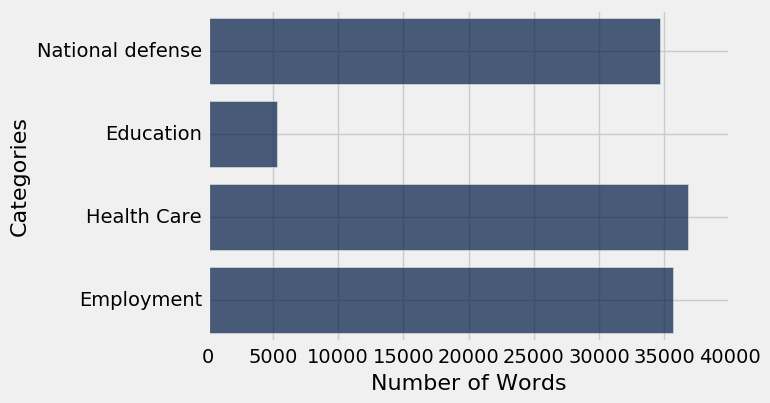

In [244]:
num_words_in_national_defense = len([word for word in all_speeches_wo_stopwords if word in national_defense_words])
num_words_in_education = len([word for word in all_speeches_wo_stopwords if word in education_words])
num_words_in_healthcare = len([word for word in all_speeches_wo_stopwords if word in health_care_words])
num_words_in_employment = len([word for word in all_speeches_wo_stopwords if word in employment_words])
category_count = Table().with_columns('Categories', make_array('National defense',  'Education', 'Health Care', 'Employment'),
                     'Number of Words', make_array(num_words_in_national_defense, num_words_in_education,
                      num_words_in_healthcare, num_words_in_employment))
category_count.show()
category_count.barh("Categories")

Categories,Number of Words,Proportion
National defense,34684,0.0476845
Education,5344,0.00734707
Health Care,36831,0.0506362
Employment,35636,0.0489933


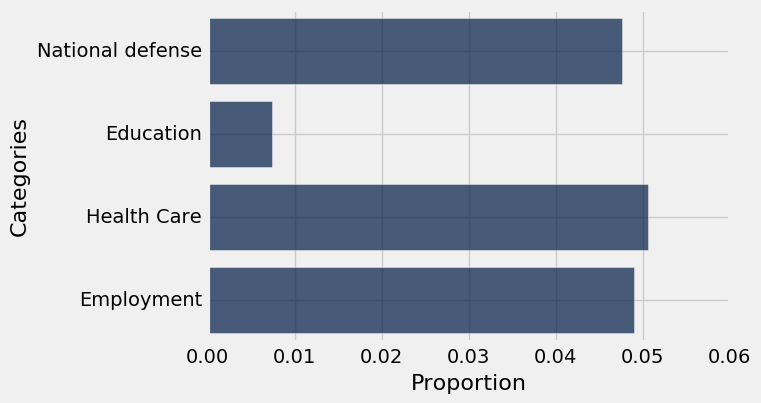

In [245]:
category_summary = category_count.with_column('Proportion', category_count['Number of Words']/len(all_speeches_wo_stopwords))
category_summary.show()
category_summary.barh("Categories", "Proportion")

## Findings:

By implementing the Topic Modeling technique, we see that with the bags of words generated under the unsupervised process, 3 out of 4 major national budget expenditure categories: National Defense, Health Care, Employment / Social Security / Labor over the span of 2008 - 2016 capture about 3-5% or about 35000 words in total within my corpus of speeches. With Education being a special case since LDA did not pick up a meaningful/useful bag of words for this category, the bag of words I manually came up with only captured about less than 1% or 5000 words of the speeches. This is what I expected since my choice of bag of words for Education was only a fraction of the size of the other categories.

I am somewhat pleased by my results since each category represented by their individual bag of words do, in fact, capture a good proportion of the words in the speeches overall. The numbers for every category except Education had roughly the same amount and were high enough for us to sample in the future for statistical analysis and hypothesis testing. We can easily randomly select thousands of words from the overall speeches and have a good degree of confidence that the sample will contain a good number of words for each category, therefore confirming the normality assumption of the Central Limit Theroem and the convergence of the expected values under Law of Large Numbers.  

Overall, by conducting this particular analysis, I learned that I need to select a bigger and more meaningful bags of words for Education since the unsupervised technique was not able to pick up patterns of words for this category as an individual grouped topic. The result also confirmed with my idea that I can be fairly confident that my analysis on National Defense, Employment, and Health Care I am about to conduct is somewhat reliable and meaningful given the corpus.

------------

## Part 2: Analysis 2
**Goal**: To assess the relevance of each topic over time to see if we can find any indication of expenditure being influenced by Obama's policies.

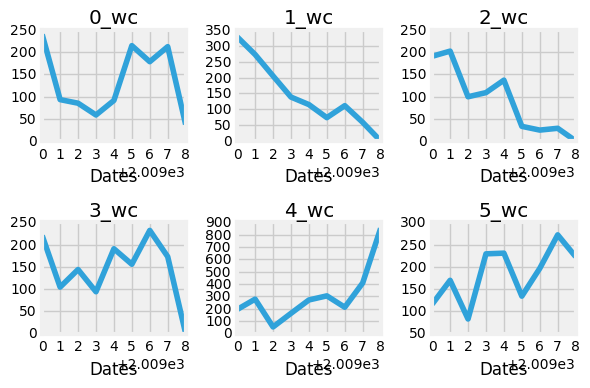

In [315]:
%matplotlib inline

topic_dist = lda.transform(tf)
topic_dist_df = pandas.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(speeches)
topic_columns = range(num_topics)
df_w_topics['word_count'] = df_w_topics['Speeches'].apply(lambda x: len(str(x).split()))
col_list = []
for num in topic_columns:
    col = "%d_wc" % num
    col_list.append(col)
    df_w_topics[col] = df_w_topics[num] * df_w_topics['word_count']
    
df_w_topics["Dates"] = [str(df_w_topics["Dates"][i])[:4] for i in range(len(df_w_topics["Dates"]))]
    
df_w_topics = df_w_topics[df_w_topics["Dates"] != "nan"]

df_w_topics["Dates"] = [int(item) for item in df_w_topics["Dates"]]
    
df_w_topics
grouped_year = df_w_topics.groupby('Dates')
fig3 = plt.figure()
chrt = 0
for e in col_list:
    chrt += 1 
    ax2 = fig3.add_subplot(2,3, chrt)
    (grouped_year[e].sum()/grouped_year['word_count'].sum()).plot(kind='line', title=e)  
    
fig3.tight_layout()
plt.show()
df_w_topics.columns = [str(i) for i in df_w_topics.columns]
df_w_topics = Table.from_df(df_w_topics).relabeled("Dates", "Year")

In [322]:
normalized_topic_relevance = df_w_topics.select(0,1,2,3,4,5).apply(lambda row: list(row) / sum(list(row)))
i = 0
for col in [[row[i] for row in normalized_topic_relevance] for i in range(len(normalized_topic_relevance[0]))]:
    df_w_topics = df_w_topics.with_column("norm " + str(i), col)
    i += 1
df_w_topics.select(7, 17, 18, 19, 20, 21, 22).group("Year", np.mean)

Year,norm 0 mean,norm 1 mean,norm 2 mean,norm 3 mean,norm 4 mean,norm 5 mean
2009,0.152913,0.197669,0.0765353,0.227031,0.0771923,0.26866
2010,0.0790785,0.200918,0.116732,0.203988,0.100228,0.299055
2011,0.141695,0.179557,0.0902847,0.295538,0.0801118,0.212813
2012,0.0899905,0.118319,0.0969814,0.173446,0.1236,0.397664
2013,0.078313,0.0702912,0.105659,0.171572,0.187208,0.386957
2014,0.165905,0.0880988,0.045554,0.275402,0.248317,0.176724
2015,0.153683,0.0909966,0.0310121,0.265052,0.185238,0.274019
2016,0.175055,0.0472806,0.017631,0.161792,0.280501,0.31774
2017,0.0130402,0.000445795,0.000446213,0.000446219,0.331844,0.653778


# Budget Data

Now we include the budget data and combine it our previous findings to see interesting results.

In [302]:
budget_data = pandas.read_excel("budget_data.xlsx", sep = '\t', encoding = 'utf-8', index_col=0)
budget_data = budget_data.drop([budget_data.index[0]])
budget_data.T
budget_data = Table.from_df(budget_data.T)
budget_data

National Defense,Human resources,"Education, Training, Employment, and Social Services",Health,Medicare,Income Security,Social Security,(On-budget),(Off-budget),Veterans Benefits and Services,Total federal outlay
661012,2.15579e+06,79749,334335,430093,533224,682963,34071,648892,95429,3.51768e+06
693485,2.38663e+06,128598,369068,451636,622210,706737,23317,683420,108384,3.45708e+06
705554,2.41474e+06,101233,372504,485653,597349,730811,101933,628878,127189,3.60306e+06
677852,2.34859e+06,90823,346742,471793,541344,773290,140387,632903,124595,3.53695e+06
633446,2.41795e+06,72808,358315,497826,536511,813551,56009,757542,138938,3.45465e+06
603457,2.52554e+06,90615,409449,511688,513644,850533,25946,824587,149616,3.50611e+06
589564,2.70682e+06,122061,482223,546202,508843,887753,30990,856763,159738,3.68829e+06
604452,2.87091e+06,113932,525860,595317,528181,929444,32779,896665,178173,3.95131e+06


### Some notes about budget categories:

- Combine Healthcare and Medicare to form 'Health' budget category.

- Combine Income Security and Social Security to form 'Employment/Social_Security' budget category.

- Total budget is the 'Total federal outlay' category.

In [303]:
budget_data['Health_Overall'] = budget_data['Health'] + budget_data['Medicare']
budget_data['Employment/Social_Security'] = budget_data['Income Security'] + budget_data['Social Security']
budget_data = budget_data.drop('Human resources', 'Health', 'Medicare', 'Income Security', 
                 'Social Security', '(On-budget)', '(Off-budget)', 'Veterans Benefits and Services')
budget_data = budget_data.relabeled('Education, Training, Employment, and Social Services', 'Education')
budget_data = budget_data.relabeled('Health_Overall', 'Health')
budget_data

National Defense,Education,Total federal outlay,Health,Employment/Social_Security
661012,79749,3.51768e+06,764428,1.21619e+06
693485,128598,3.45708e+06,820704,1.32895e+06
705554,101233,3.60306e+06,858157,1.32816e+06
677852,90823,3.53695e+06,818535,1.31463e+06
633446,72808,3.45465e+06,856141,1.35006e+06
603457,90615,3.50611e+06,921137,1.36418e+06
589564,122061,3.68829e+06,1.02842e+06,1.3966e+06
604452,113932,3.95131e+06,1.12118e+06,1.45762e+06


### Budget Data Visualizations through different years across the four budget categories:

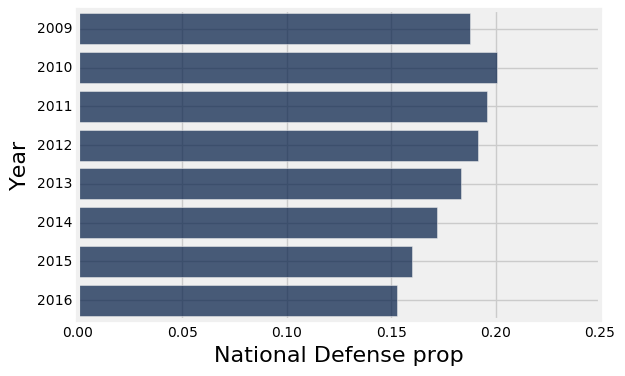

In [305]:
budget_data['Year'] = [i for i in range(2009, 2017)]#['2009', '2010', '2011', '2012' ,'2013', '2014', '2015', '2016']
budget_data['National Defense prop'] = budget_data['National Defense'] / budget_data['Total federal outlay']
budget_data.barh("Year", "National Defense prop")

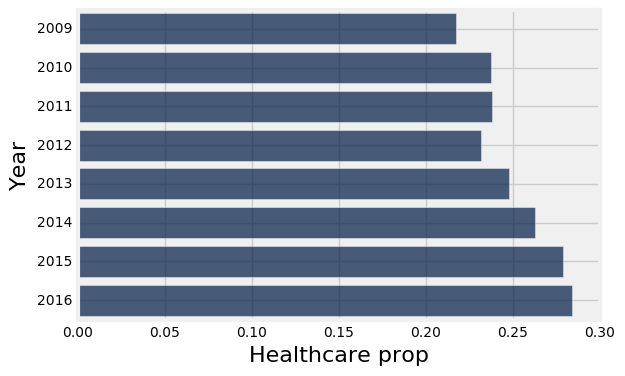

In [306]:
budget_data['Healthcare prop'] = budget_data['Health'] / budget_data['Total federal outlay']
budget_data.barh("Year", "Healthcare prop")

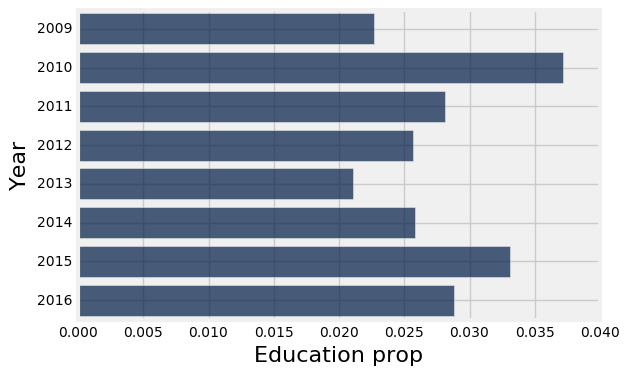

In [307]:
budget_data['Education prop'] = budget_data['Education'] / budget_data['Total federal outlay']
budget_data.barh("Year", "Education prop")

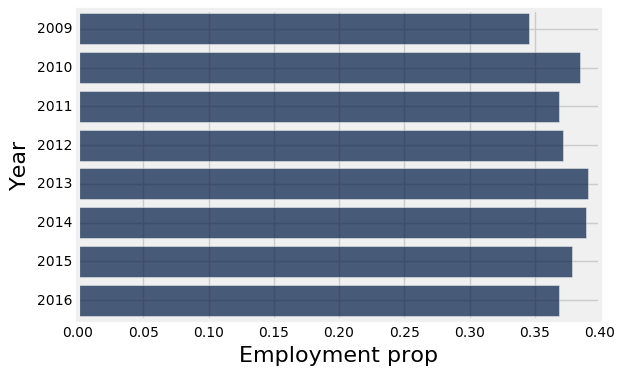

In [308]:
budget_data['Employment prop'] = budget_data['Employment/Social_Security'] / budget_data['Total federal outlay']
budget_data.barh("Year", "Employment prop")

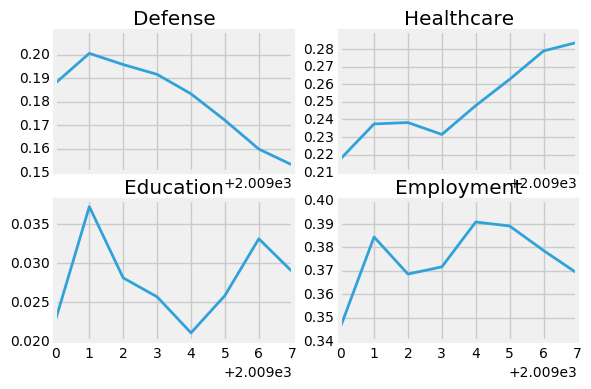

In [323]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
#plt.ylim(0, 0.5)
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(budget_data['Year'], budget_data['National Defense prop'], lw=2, label='Defense')
axarr[0, 0].set_title('Defense')
axarr[0, 1].plot(budget_data['Year'], budget_data['Healthcare prop'], lw=2, label='Healthcare')
axarr[0, 1].set_title('Healthcare')
axarr[1, 0].plot(budget_data['Year'], budget_data['Education prop'], lw=2, label='Education')
axarr[1, 0].set_title('Education')
axarr[1, 1].plot(budget_data['Year'], budget_data['Employment prop'], lw=2, label='Employment')
axarr[1, 1].set_title('Employment')
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
#plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
plt.show();

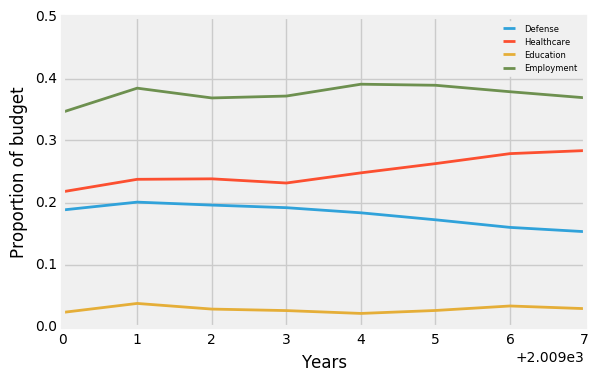

In [310]:
plt.ylim(0, 0.5)
plt.plot(budget_data['Year'], budget_data['National Defense prop'], lw=2, label='Defense')
plt.plot(budget_data['Year'], budget_data['Healthcare prop'], lw=2, label='Healthcare')
plt.plot(budget_data['Year'], budget_data['Education prop'], lw=2, label='Education')
plt.plot(budget_data['Year'], budget_data['Employment prop'], lw=2, label='Employment')
plt.xlabel('Years')
plt.ylabel('Proportion of budget')
plt.legend(prop={'size':6});